In [1]:
import torch
import math
from SC_IPFP.torch.utils import NN, log_kde_pdf_per_point, silvermans_rule
from SC_IPFP.torch.sde_solvers_time import solve_sde_RK


from tqdm.notebook import tqdm



import itertools
from functools import partial
# np = jax.numpy
import matplotlib.pyplot as plt

In [2]:
def solve_sde_RK(alfa=None, beta=None, X0=None, dt=1.0, N=100, t0=0.0,
                theta=None, noise=False, forwards=True):
    """
            Euler Mayurama method
    Syntax:
    ----------
    solve_sde(alfa=None, beta=None, X0=None, dt=None, N=100, t0=0, DW=None)
    Parameters:
    ----------
        alfa  : a  function with two arguments, the X state and the time
                defines the differential equation.
        beta  : a  function with two arguments, the X state and the time
                defines the stochastic part of the SDE.
        X0    : Initial conditions of the SDE. Mandatory for SDEs
                with variables > 1 (default: gaussian np.random)
        dt    : The timestep of the solution
                (default: 1)
        N     : The number of timesteps (defines the length of the timeseries)
                (default: 100)
        t0    : The initial time of the solution
                (default: 0)
    
    """
    
#     print(X0)
       
    if alfa is None or beta is None:
        raise ValueError("Error: SDE not defined.")

    n, d, *_ = X0.shape
    
    T = torch.tensor(dt * N).cuda()
    
    DWs  = torch.empty((n, N-1, d)).normal_(mean=0, std=1).cuda() * math.sqrt(dt)
    
    
    Y, ti = torch.zeros((n, N, d + 1)).double().cuda(), torch.arange(N).double().cuda()*dt + t0
    t0rep =  (
        t0 * torch.ones((X0.shape[0], 1)).double().cuda() if forwards
        else (T-t0) * torch.ones((X0.shape[0], 1)).double().cuda()
    )
#     Y[:, 0, :] =  torch.cat((X0, t0rep), axis=1 )
    ixs = torch.arange(3, dtype=torch.int64)
    Y = torch.cat((X0, t0rep), axis=1 )[:, None, :]

    N = int(N)
    
    T = dt * N
        
    for n in range(N-1):
        t = ti[n]
        a, DW_n = alfa(Y[:,n, :]),  DWs[:,n,:]
        newY = (  
            Y[:,n, :-1] + a * dt + beta * DW_n
        )
        
        trep = (
            t.repeat(newY.shape[0]).reshape(-1,1) if forwards
            else T - t.repeat(newY.shape[0]).reshape(-1,1)
        )
        
        tocat = torch.cat((newY, trep), dim=1)[:, None, :]
        Y = torch.cat((Y,tocat) , dim=1)
        if torch.isnan(Y).any() or torch.isinf(Y).any(): import pdb; pdb.set_trace()
#     import pdb; pdb.set_trace()
    return ti, Y

In [3]:
class cIPFP(object):
    
    def __init__(self, X_0, X_1, weights=[100], batch_size=None,  rng = None, rng_b = None, 
                nrng = None, number_time_steps=16, sde_solver=solve_sde_RK, sigma_sq=1, 
                step_size = 0.001, num_epochs = 10, momentum_mass = 0.9, create_network=None,
                log_prob=log_kde_pdf_per_point, optimizer=torch.optim.SGD):
        
        self.sde_solver = sde_solver
        
        self.number_time_steps = number_time_steps
        self.dt = 1.0 / number_time_steps
        
        
        self.batch_size_f = X_0.shape[0] if batch_size is None else batch_size
        self.batch_size_b = X_1.shape[0] if batch_size is None else batch_size
        with torch.cuda.device(0):
        
            self.X_0 = X_0
            self.X_1 = X_1

            self.H_0 = silvermans_rule(X_0)
            self.H_1 = silvermans_rule(X_1)

            _, self.dim = self.X_0.shape

            weights = weights + [self.dim]


            self.b_forward = NN(self.dim + 1, weights).double().cuda()
            self.b_backward = NN(self.dim + 1, weights).double().cuda()

            self.theta_f = list(self.b_forward.parameters())
            self.theta_b = list(self.b_backward.parameters())

            self.sigma = sigma_sq

            self.optimizer_f = optimizer(
                self.theta_f, lr=step_size
            )

            self.optimizer_b = optimizer(
                self.theta_b, lr=step_size
            )

            num_complete_batches_f, leftover_f = divmod(self.X_0.shape[0], self.batch_size_f)
            self.num_batches_f = num_complete_batches_f + bool(leftover_f)

            num_complete_batches_b, leftover_b = divmod(self.X_1.shape[0], self.batch_size_b)
            self.num_batches_b = num_complete_batches_b + bool(leftover_b)

            self.first_iter_fac = 0.0

            self.log_prob = log_prob

            self.burn_in = False
    
    def data_stream(self, forward=True):
        X = self.X_0 if forward else self.X_1
        
        batch_size = self.batch_size_f if forward else self.batch_size_b
        num_batches = self.num_batches_f if forward else self.num_batches_b
        
        num_train = self.X_0.shape[0] if forward else self.X_1.shape[0]
        while True:
            perm = torch.randperm(X.size()[0])
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield X[batch_idx] 
        
    def loss_for_trajectory(self, Xt, forwards):
        n_, *_ = Xt.shape
        
        if not forwards :
            Xt = Xt.flip(1)
        
        if forwards:
            b_minus  = self.b_backward.forward( Xt)
            b_plus = self.b_forward.forward(Xt)
        else:
            b_minus  = self.first_iter_fac * self.b_backward.forward(Xt)
            b_plus = self.b_forward.forward(Xt)

            
        delta_Xt = Xt[:, 1:, :] - Xt[:, :-1, :]  
        
        sign = 1.0 if forwards else -1.0
        
        ito_integral = sign *  (b_plus[:, :-1,:] - b_minus[:, 1:,:])  * delta_Xt
        
        time_integral = sign *  (b_plus**2 - b_minus**2) * self.dt 
        
        out =  ito_integral.sum(axis=(1,2)) - 0.5 * time_integral.sum(axis=(1,2))
        
        return out


    def inner_loss_jit(self, batch,  
                       batch_terminal_empirical,
                       H,  forwards):
        
        b = (
            self.b_forward.forward
            if forwards else (lambda X: -self.b_backward.forward(X))
        )
        
        t, Xt, *W = self.sde_solver(
            b, self.sigma, batch, self.dt, 
            self.number_time_steps, 0,
            None, False, forwards
        )
        Ht = silvermans_rule(Xt[:,-1,:-1])
        H = silvermans_rule(batch_terminal_empirical)
        
        main_term = self.loss_for_trajectory(Xt, forwards)
        print( "term", torch.abs(main_term).max())
#         entropy = 0 #-log_kde_pdf_per_point(Xt[:,-1,:-1], Xt[:,-1,:-1], Ht) *  0
        if not self.burn_in:
            cross_entropy = -self.log_prob( Xt[:,-1,:-1], batch_terminal_empirical, H)             
        else:
            cross_entropy = -self.log_prob(batch_terminal_empirical, Xt[:,-1,:-1], Ht)
#             main_term = 0 

        J = torch.mean(main_term + 2.0 * cross_entropy )
        J = torch.squeeze(J)
        return J
    
    def inner_loss(self, batch, forwards=True):
        
        if self. burn_in:
            self.batch_terminal_empirical_burn = next(self.data_stream(forward=forwards))
            self.H_burn = self.H_0 if forwards else self.H_1
#         else:
        batch_terminal_empirical = next(self.data_stream(forward=not(forwards)))
        H = self.H_1 if forwards else self.H_0

        return self.inner_loss_jit(
            batch, batch_terminal_empirical,
            H,  forwards
        )

    def closure(self, X, forwards=True):
        """
        Close method required for pytorches CG and LBFGS optimizers
        :params X[torch.tensor]: nxdim  torch tensor representing dataset
        """
        
        opt = self.optimizer_f if forwards else self.optimizer_b
        
        opt.zero_grad()
        loss = self.inner_loss(X, forwards)
        loss.backward()
        return loss
    
    
    def fit(self, IPFP_iterations=10, sub_iterations=10, plot=False, burn_iterations=7):     
        
        name = str(self.optimizer_f).lower()
        bfgs_cg_flag  = "bfgs" in name or "cg" in name
        close_f, close_b =  [], []

        
        
        if plot: self.plot_trajectories()
        
        self.first_iter_fac = 0.0
        if burn_iterations > 0 : self.burn_in = True
            
        
        batches_f = self.data_stream(forward=True)
        batches_b = self.data_stream(forward=False)
        
        loss_b, loss_f = [], []
        for i in tqdm(range(IPFP_iterations + burn_iterations)):
            
            if i == burn_iterations:
                self.burn_in = False
                self.first_iter_fac = 0.0
            
            
            for k in range(sub_iterations):
                for _ in range(self.num_batches_b):
                    batch_b =  next(batches_b)
                    
                    if bfgs_cg_flag:
                        close_b = [lambda : self.closure(batch_b, False)]
                    lossb = self.inner_loss(
                        batch_b, False
                    )
                    lossb.backward()
                    self.optimizer_b.step(*close_b)
                print(f"loss b {lossb}")
            loss_b.append(lossb)

            self.first_iter_fac = 1.0
       
            for k in range(sub_iterations):
                for _ in range(self.num_batches_f):
                    batch_f =  next(batches_f)
                    if bfgs_cg_flag:
                        close_f = [lambda : self.closure(batch_f, True)]
                    lossf = self.inner_loss(
                        batch_f, True
                    )
                    
                    lossf.backward()
                    self.optimizer_f.step(*close_f)
  
                print(f"loss f {lossf}")
            loss_f.append(lossf)


            self.loss_f = loss_f
            self.loss_b = loss_b
            if plot: self.plot_trajectories()

        
        plt.plot(range(IPFP_iterations), loss_f, "g")
        plt.show()
        plt.plot(range(IPFP_iterations), loss_b, "b")
        plt.show()
        
    def plot_trajectories(self):
        bb = lambda X: -self.b_backward(X)

        t, Xts = c.sde_solver(
            self.b_forward.forward, self.sigma,
            self.X_0, self.dt,  self.number_time_steps, 0.0,
            self.theta_f, False, True
        )
        t_, Xts_ = c.sde_solver(
            bb, self.sigma, 
            self.X_1, self.dt, self.number_time_steps, 0.0, 
            self.theta_b, False, False
        )
        
        fn = 14
        fig, axs = plt.subplots(2,1,  sharey=False, figsize=(15,10))
        axs[1].set_xlabel("$t$", fontsize=fn)
        axs[1].set_ylabel("$x(t)$", fontsize=fn)
        axs[0].set_ylabel("$x(t)$", fontsize=fn)

        tt = axs[1].get_xticks()
        axs[1].set_xticks(tt.flatten() )
        axs[1].set_xticklabels(list(map (lambda x: '{0:.2f}'.format((x)), tt))[::-1])

        for i in range(n):
            label = "$\mathbb{Q}$: Forward process" if i == 0 else None
            axs[0].plot(t.cpu().flatten(), Xts[i,:,:-1].detach().cpu().numpy().flatten(), 'b', alpha=0.03,  label=label)


        for i in range(n):
            label = "$\mathbb{P}$: Reverse process" if i == 0 else None
            axs[1].plot(t_.cpu().flatten(), Xts_[i,:, :-1].detach().cpu().numpy().flatten(), 'r', alpha=0.03, label=label)

        axs[1].legend(fontsize=fn)
        axs[0].legend(fontsize=fn)

        plt.show()    
    
    #     @partial(jit, static_argnums=(0,2))
    def transport_batch(self, batch_x, forwards):
        theta = self.theta_f if forwards else self.theta_b    
        b = self.b_forward if forwards else  lambda X, theta: -self.b_backward(X, theta)

        t, Xt = self.sde_solver(
            alfa=b, beta=self.sigma, dt=self.dt, 
            X0=batch_x.reshape(-1,self.dim), N=self.number_time_steps, theta=theta
        )

        return Xt[:,-1,:]
            

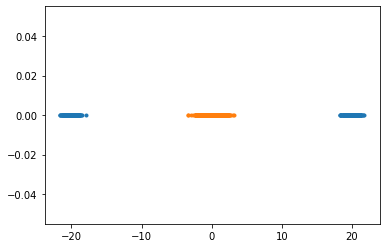

In [4]:
import numpy.random as npr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

n = 900
n_2 = int(n * 1.0 / 3)

X1 = npr.randn(n).reshape(-1,1) - 0
X21 = 0.6 * npr.randn(n_2).reshape(-1,1) + 20
X22 =  0.6 * npr.randn(n_2).reshape(-1,1) -20
X23 =  0.6 * npr.randn(n_2).reshape(-1,1) + 20

X2 = np.concatenate((X21, X22, X23), axis=0)
# X1, X2 = X2, X1

plt.plot(X2.flatten(), [0] * n, '.')
plt.plot(X1.flatten(), [0] * n, '.')

with torch.cuda.device(0):

    X1 = torch.tensor(X1).cuda()
    X2 = torch.tensor(X2).cuda()

In [15]:
c = cIPFP(
    X1, X2,  number_time_steps=100, batch_size=900 ,
    step_size = 1e-3, weights=[500, 200, 100], rng = None, optimizer=torch.optim.AdamW
)

/auto/homes/fav25/SC-IPFP/SC_IPFP/torch/utils.py:73: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.layers[i].weight)


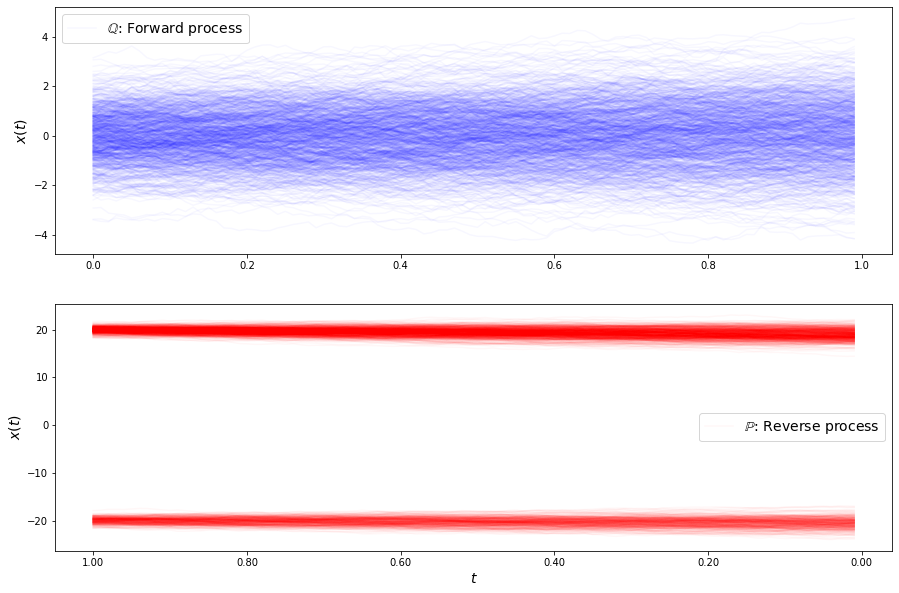

term tensor(2.8266, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1957.1521663694948
term tensor(4.4795, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1386.4380018314666
term tensor(5.0136, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1017.2912997179324
term tensor(5.8476, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 771.4590120570263
term tensor(6.3342, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 572.4427306303402
term tensor(6.9488, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 412.40541571311485
term tensor(7.4094, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 297.5977721438206
term tensor(7.7512, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 203.24220161543224
term tensor(7.6961, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 136.6548270177328
term tensor(7.8878, device='cuda

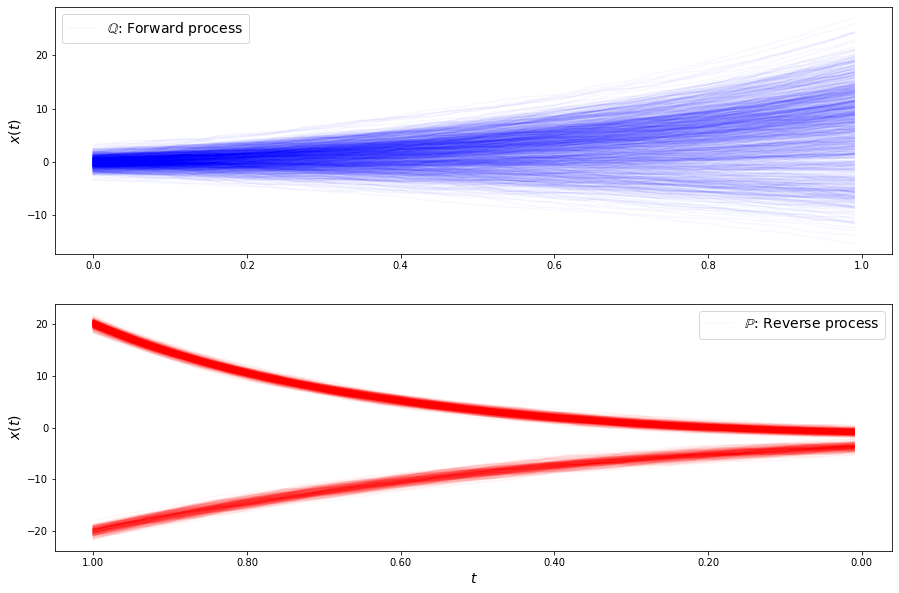

term tensor(106.3201, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 58.36619797762342
term tensor(134.5609, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 76.7871387216841
term tensor(165.7550, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 96.52584273668379
term tensor(199.4322, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 119.25349099521108
term tensor(231.4303, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 144.06095929891873
term tensor(265.9372, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 170.00888964306031
term tensor(303.5798, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 195.82404267515165
term tensor(365.5857, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 221.59335091007813
term tensor(370.3579, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 248.0488437576846
term tensor(399

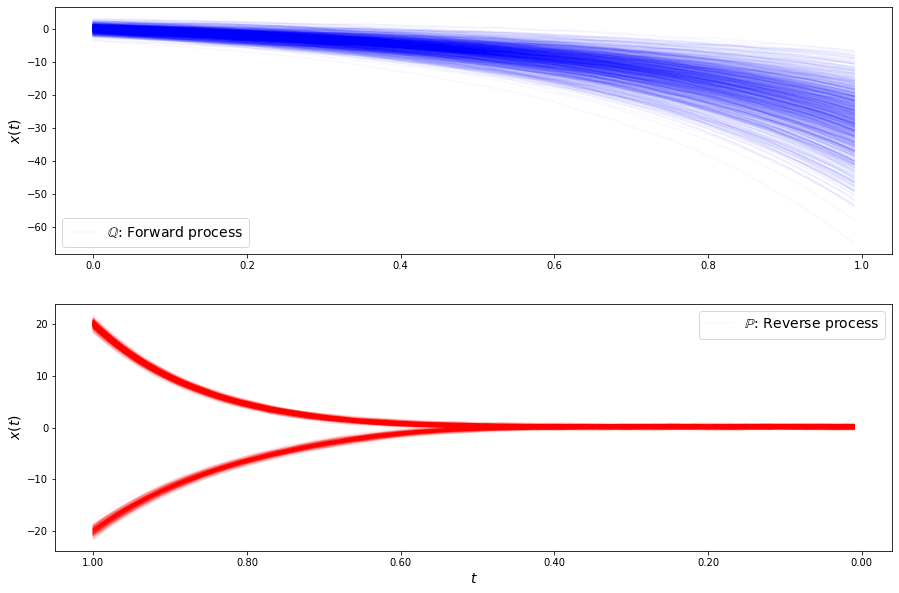

term tensor(823.1900, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 521.4897530676234
term tensor(801.2965, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 521.840050840226
term tensor(796.0383, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 510.82906036208453
term tensor(763.5145, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 489.1703609218122
term tensor(712.6814, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 459.51955944619624
term tensor(642.7510, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 426.0893117743323
term tensor(609.5911, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 386.65664065144506
term tensor(524.8944, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 342.95943533802097
term tensor(463.2086, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 297.47641447689983
term tensor(400

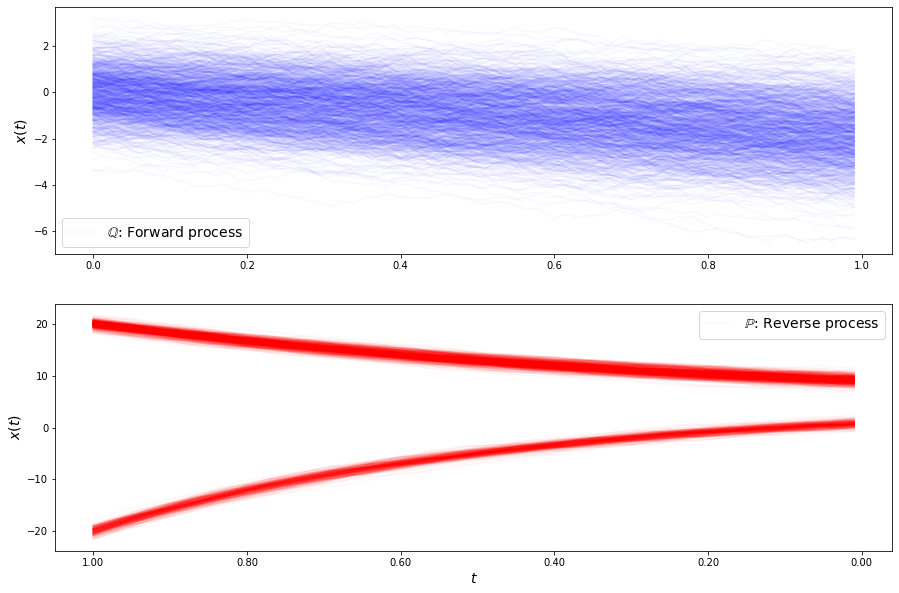

term tensor(234.4799, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 314.5610116295171
term tensor(189.4778, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 601.9086870061075
term tensor(160.2306, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1234.2214954602923
term tensor(140.4358, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 2073.1505393650373
term tensor(107.5099, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 2606.1945181771152
term tensor(67.1079, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 2369.384562482025
term tensor(41.7705, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1692.0652783682224
term tensor(24.1703, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1090.0388766027436
term tensor(62.3510, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 743.8774603009422
term tensor(112.39

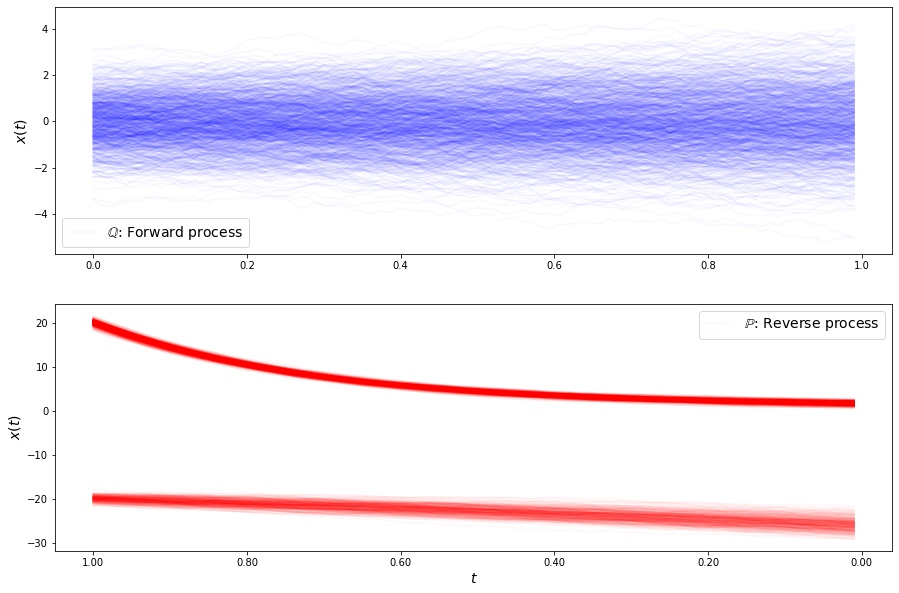

term tensor(381.8651, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1446.5749104396614
term tensor(439.8663, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1467.1081431208202
term tensor(497.2372, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1447.4631257855553
term tensor(564.6845, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1372.1703782754196
term tensor(606.4603, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1269.2204723967552
term tensor(647.7569, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1186.6452013589085
term tensor(691.9997, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1104.1310947674797
term tensor(773.2853, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1029.780190719295
term tensor(799.2766, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 967.4084451368942
term tensor(

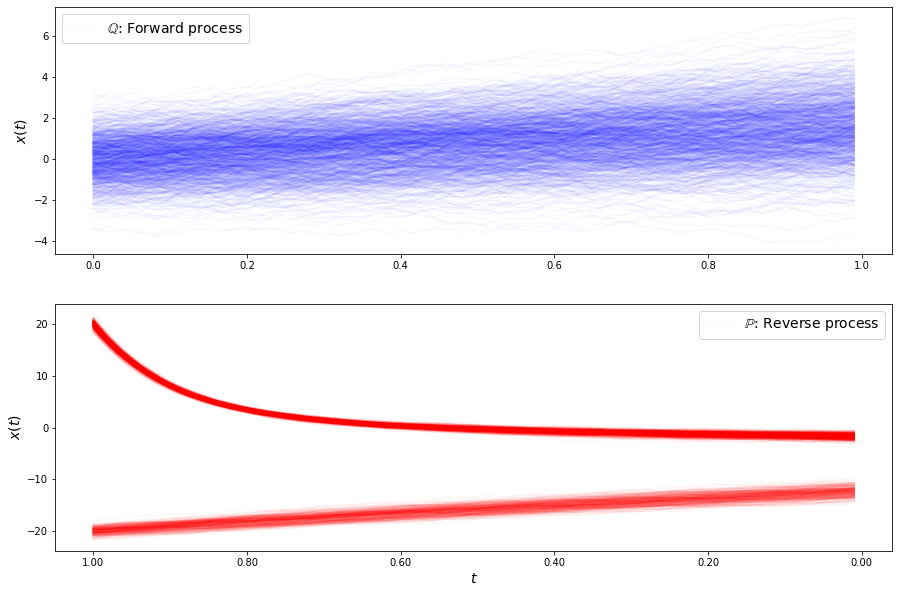

term tensor(878.4141, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 699.6377530094023
term tensor(911.7759, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 694.7382755426424
term tensor(938.3303, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 693.7646725301573
term tensor(1003.9536, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 692.075608130936
term tensor(983.7675, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 688.3829553639476
term tensor(1012.6391, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 690.394749908834
term tensor(1034.7645, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 684.824836984364
term tensor(1027.8795, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 685.36004299713
term tensor(1014.2022, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 681.0664022268344
term tensor(1063.83

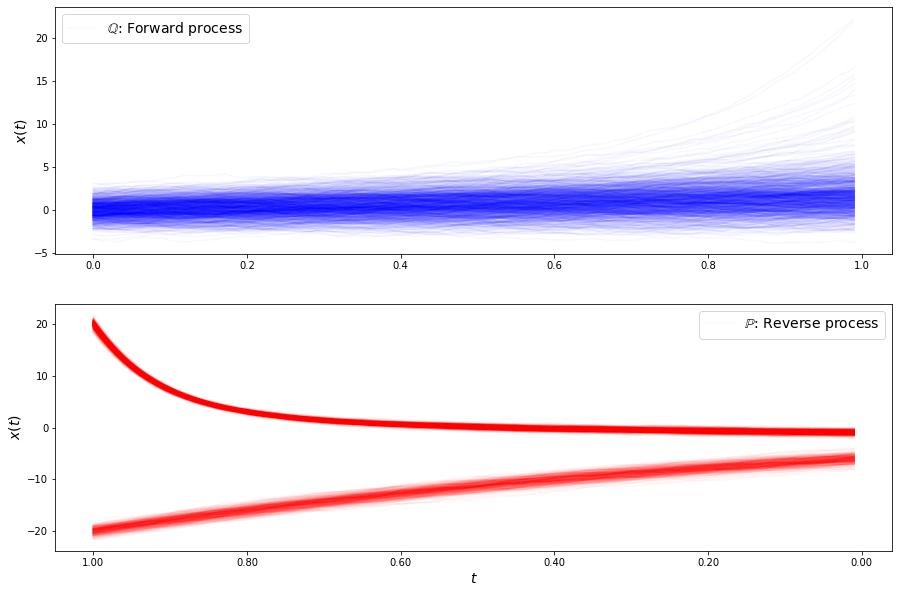

term tensor(653.2896, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 413.80385819940403
term tensor(649.9688, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 399.22869480356263
term tensor(597.7097, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 383.203664986874
term tensor(575.9441, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 363.9294623573866
term tensor(566.2257, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 344.18170878203847
term tensor(510.0220, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 320.989803388886
term tensor(453.1697, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 296.9055257973034
term tensor(432.5149, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 272.72717322699714
term tensor(364.4939, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 245.9609773609877
term tensor(312.1

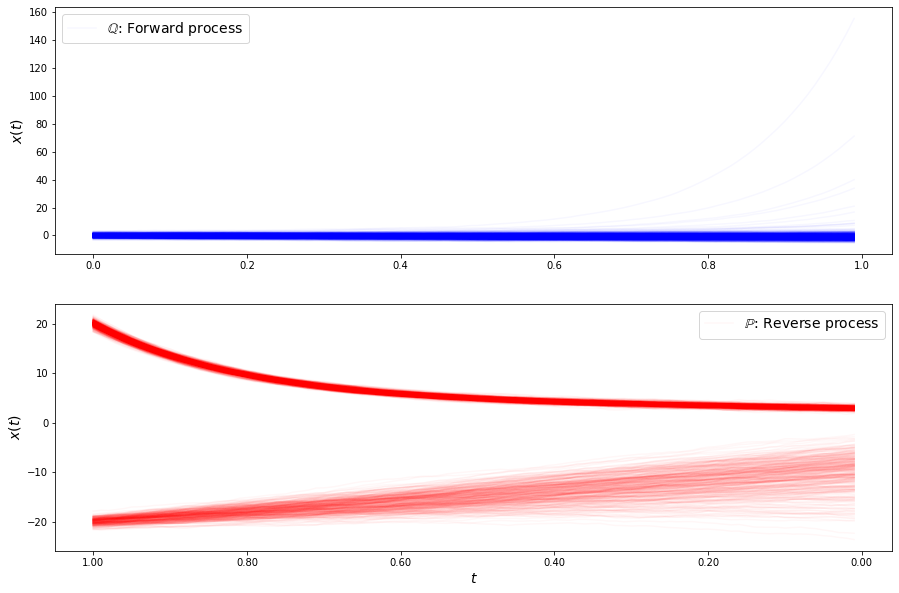

term tensor(274.6966, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 291.1494895271159
term tensor(381.7339, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 679.207737806974
term tensor(499.8268, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 386.8381659753743
term tensor(583.0686, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 352.55586055275796
term tensor(670.8499, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 412.1620018674732
term tensor(684.6031, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 450.3377879902891
term tensor(685.2523, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 455.5652252652892
term tensor(608.2218, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 439.2634979983564
term tensor(522.8527, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 404.3343325287995
term tensor(469.513

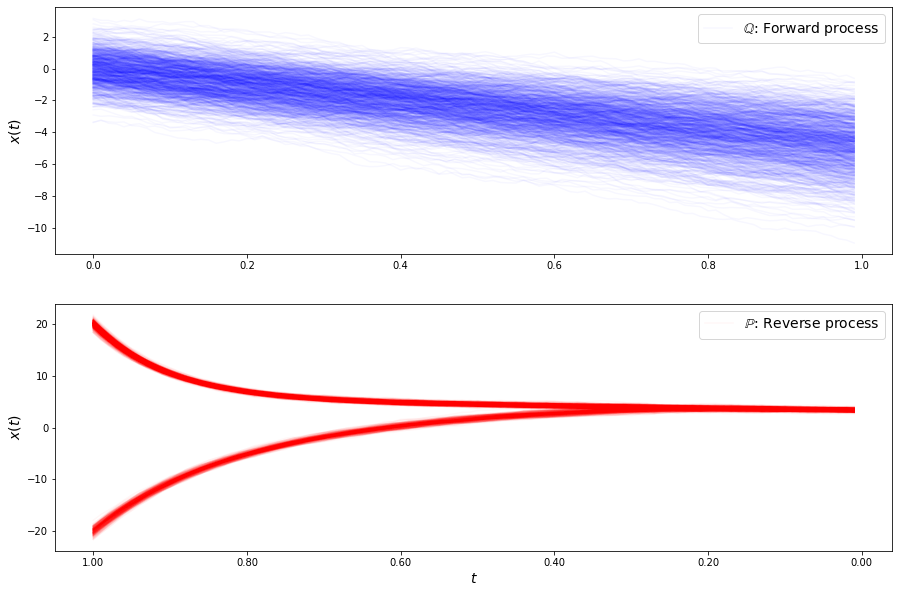

term tensor(947.2773, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 699.3287105345192
term tensor(1026.0625, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 757.684436709512
term tensor(1097.8001, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 816.6028126037339
term tensor(1222.1023, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 877.7472151275324
term tensor(1275.0379, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 939.9028798308716
term tensor(1362.6517, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1005.5673895085462
term tensor(1473.0777, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1068.735317527029
term tensor(1547.2606, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1135.3088698347813
term tensor(1650.7551, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1200.8258369325495
term tens

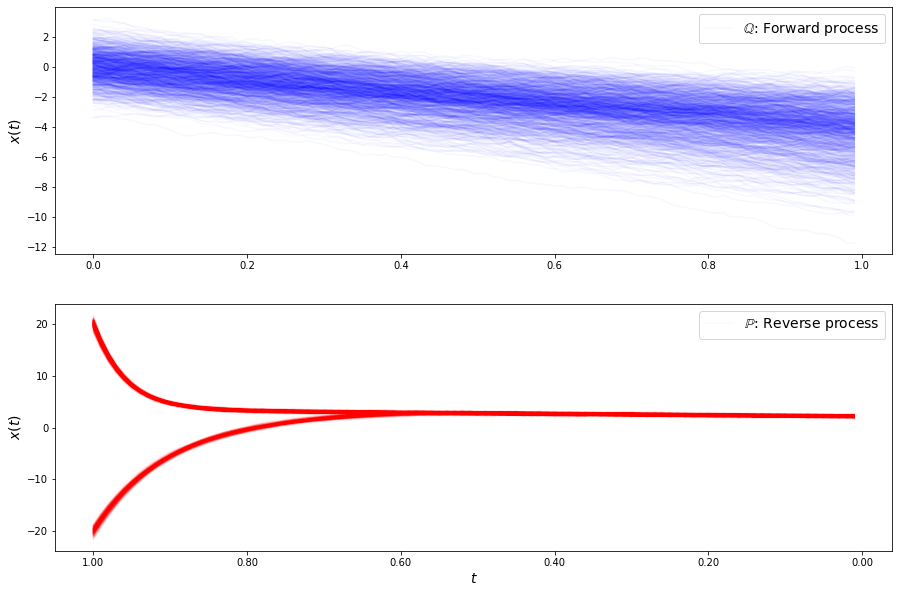

term tensor(2372.3394, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1676.7622690005285
term tensor(2397.7988, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1730.1914753091755
term tensor(2484.3534, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1780.2415718921845
term tensor(2577.2956, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1824.4447690733425
term tensor(2622.4650, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1863.5953484218626
term tensor(2662.1612, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1898.4306851302483
term tensor(2745.3054, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1928.5593752467228
term tensor(2865.2734, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1952.4895993350299
term tensor(2867.8256, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1972.7467138328757
t

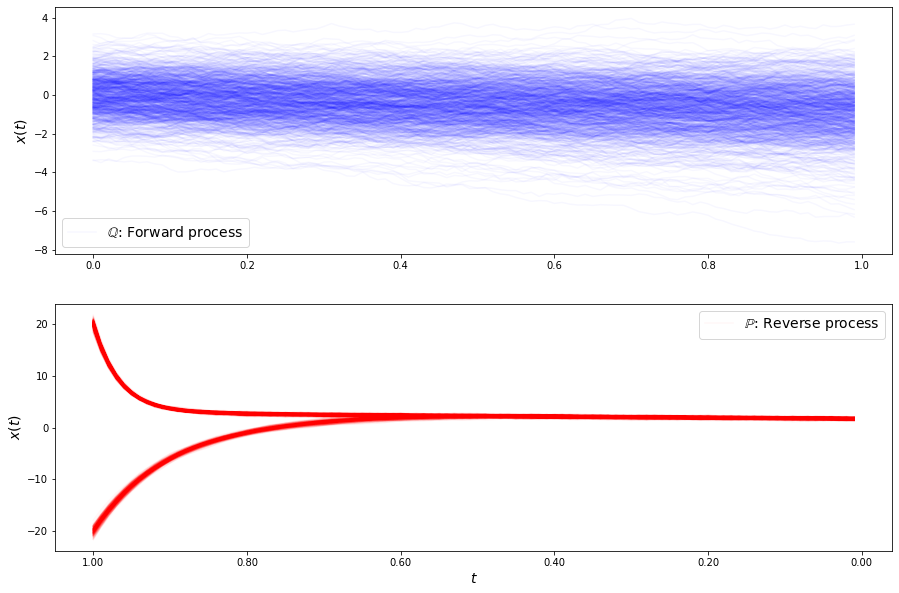

term tensor(2772.2329, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1857.739445220537
term tensor(2728.2681, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1838.3187746994527
term tensor(2668.8105, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1807.7650143511005
term tensor(2645.7214, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1778.3529037266958
term tensor(2619.6601, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1743.7143482380623
term tensor(2576.4435, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1701.8964130343652
term tensor(2525.3172, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1655.568701009042
term tensor(2498.6786, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1608.7655751558611
term tensor(2384.8906, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1560.4849112839047
ter

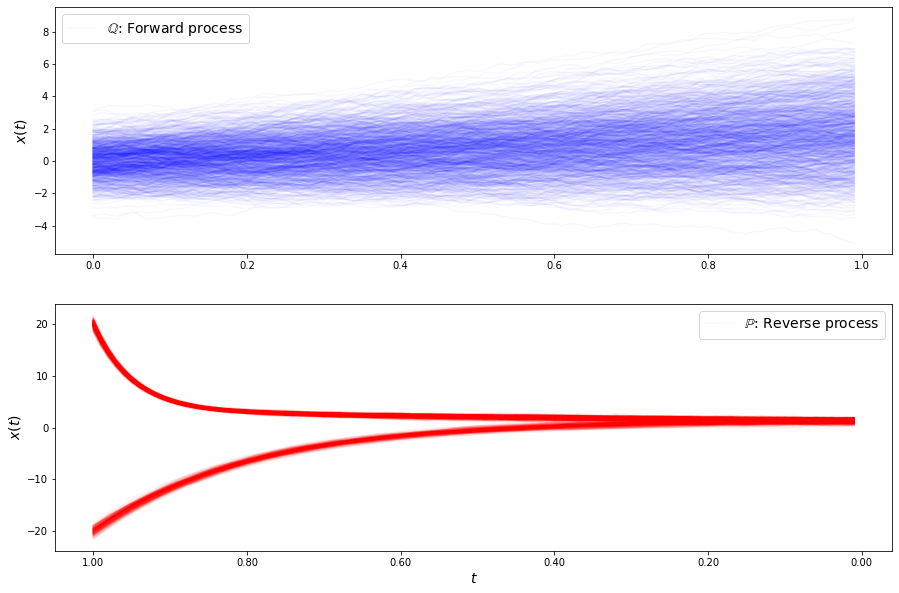

term tensor(1623.6709, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 993.0604359366754
term tensor(1525.6502, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 929.0010260908614
term tensor(1428.0537, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 862.3812144950878
term tensor(1319.8012, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 795.7090650375304
term tensor(1243.1481, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 728.8818932639388
term tensor(1195.4302, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 663.515780239872
term tensor(1053.4743, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 598.0872333649959
term tensor(971.6836, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 535.4308760618679
term tensor(875.9295, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 478.79616674302406
term tensor(

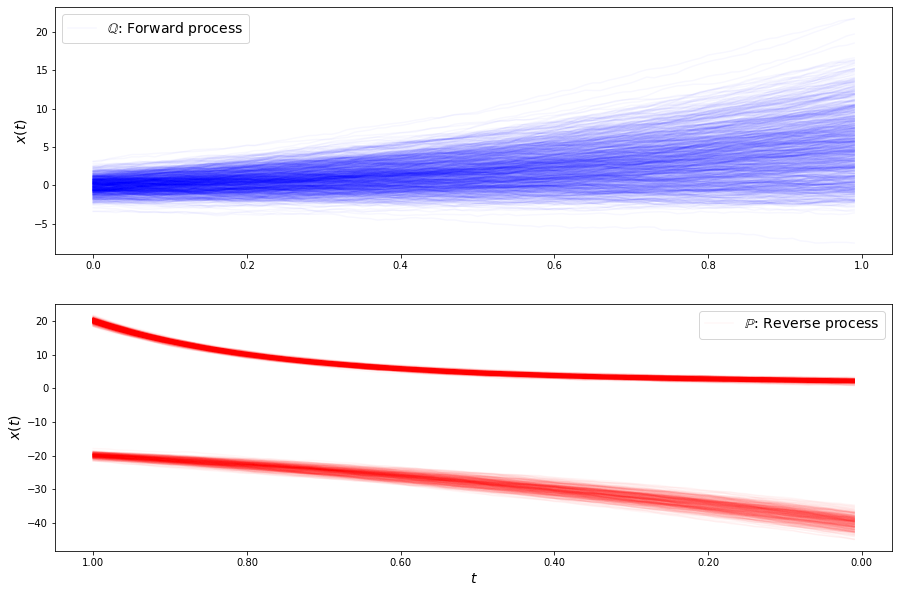

term tensor(2161.7164, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 3767.449220039715
term tensor(1477.7351, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 3098.795483332688
term tensor(960.5012, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 1911.429638126019
term tensor(467.4679, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 932.0196073424374
term tensor(152.0827, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 459.1086012156396
term tensor(269.1004, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 720.0634525206214
term tensor(998.1814, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 2572.6911795324017
term tensor(2444.4696, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 6662.4760940719925
term tensor(2348.8203, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 6470.070408699721
term tensor(1

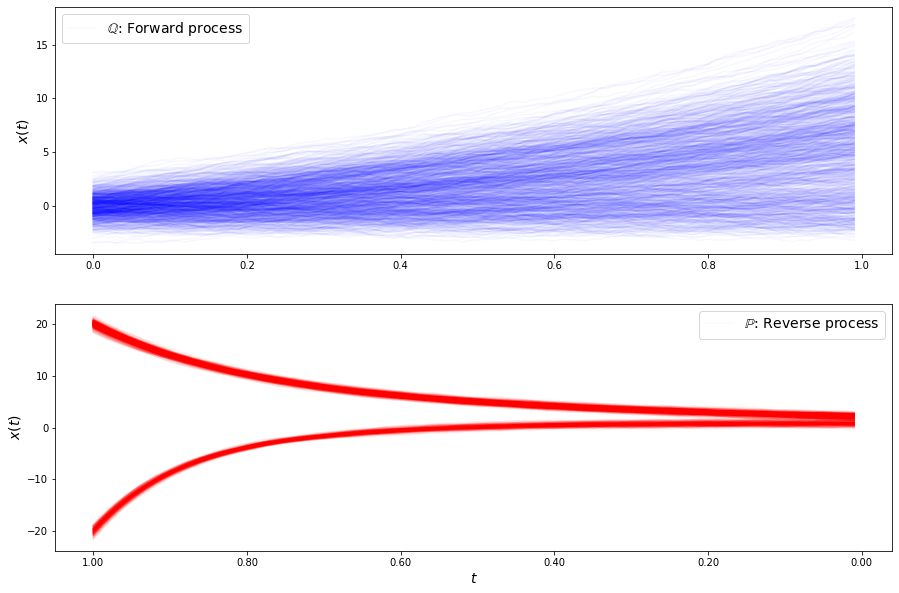

term tensor(1165.6936, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 396.85106488994796
term tensor(1268.1423, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 463.5299965967713
term tensor(1417.7449, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 533.7284708412418
term tensor(1492.3609, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 608.135197638474
term tensor(1641.8228, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 685.218865519346
term tensor(1758.5337, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 761.8873733741175
term tensor(1899.7677, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 838.6173437047393
term tensor(2012.0815, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 918.0160072881159
term tensor(2159.5844, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
loss b 998.5634316688064
term tensor

In [ ]:
torch.autograd.set_detect_anomaly(True)
c.fit(1900, 15, burn_iterations=0, plot=True)

In [ ]:
plt.plot(c.loss_f)
plt.show()
plt.plot(c.loss_b)

In [224]:
X = torch.linspace(-10, 10, 100).reshape(100, 1)
t = torch.ones(100).reshape(100, 1)
Xt = torch.cat((X,t), dim=1).cuda().double().requires_grad_()
print(Xt.shape)

torch.autograd.functional.jacobian(c.b_forward.forward, Xt).shape

torch.Size([100, 2])


torch.Size([100, 1, 100, 2])

In [225]:
B = c.b_forward.forward(Xt)

In [228]:
c.b_forward.forward

test = torch.autograd.grad(B, Xt, torch.ones_like(B), retain_graph=True)[0].shape

torch.Size([100, 2])

In [243]:
xx = Xt[0,:].reshape(1,-1).double().cuda().requires_grad_()

test2 = c.b_forward.forward(xx)
test2

tensor([[-0.1342]], device='cuda:0', dtype=torch.float64,
       grad_fn=<AddmmBackward>)

In [244]:
print(torch.autograd.grad(test2, xx, torch.ones_like(test2), retain_graph=True))

(tensor([[-0.0120, -0.5032]], device='cuda:0', dtype=torch.float64),)


In [ ]:
def compute_jacobian(f, x, output_dims):
    '''
    Normal:
        f: input_dims -> output_dims
    Jacobian mode:
        f: output_dims x input_dims -> output_dims x output_dims
    '''
    repeat_dims = tuple(output_dims) + (1,) * len(x.shape)
    jac_x = x.detach().repeat(*repeat_dims)
    jac_x.requires_grad_()
    jac_y = f(jac_x)
    
    ml = torch.meshgrid([torch.arange(dim) for dim in output_dims])
    index = [m.flatten() for m in ml]
    gradient = torch.zeros(output_dims + output_dims)
    gradient.__setitem__(tuple(index)*2, 1)
    
    jac_y.backward(gradient)
        
    return jac_x.grad.data